# Local Energy Market

The goals of this system are to:<br>
-Provide consumer choice, allowing people to buy and sell power according
to a number of attributes such as carbon intensity or price;<br>
-Retain revenue within the local area;<br>
-Efficiently distribute power, reducing the load on wiring and external
networks.

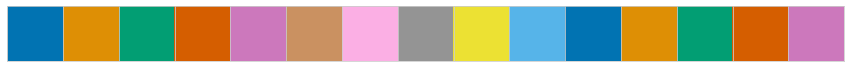

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns

sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
fig_format = "png"
dpi = 1000
figsize = (12, 3.5)
figsize_map = (10, 6)
sns.palplot(sns.color_palette())

## Functions used for creating a local energy market

In [2]:
# Remove special characters from the column values 
def cleanColumn(df, target_col):
    df[target_col] = df[target_col].str.replace('<', '')
    df[target_col] = df[target_col].str.replace('>', '')
    df[target_col] = df[target_col].str.replace('=', '')
    df[target_col] = df[target_col].astype(float)
    return True


#Returns the clearing value from a set of bids from generators and consumers 
#for a specified target: price, CO2, etc.. 
def getClearingValues(df_gen, df_cons, target):
    
    df_gen.sort_values(target, inplace=True, ascending=True)
    df_gen['Cumulative_volume'] = df_gen['volume_kwh'].cumsum()
    
    df_cons.sort_values(target, inplace=True, ascending=False)
    df_cons['Cumulative_volume'] = df_cons['volume_kwh'].cumsum()
    
    clearing_target = df_gen[target].max()
    clearing_volume = df_gen['Cumulative_volume'].max()
    
    for index_gen, row_gen in df_gen.iterrows():
        volume_gen = row_gen['Cumulative_volume']
        target_gen = row_gen[target]
        
        temp_df_bids_consumers = df_cons.loc[df_cons['Cumulative_volume']<=volume_gen, :]
        if len(temp_df_bids_consumers)>0:
            row_cons = df_cons.loc[df_cons['Cumulative_volume']<=volume_gen, :].iloc[-1]
            target_cons = row_cons[target]
            volume_cons = row_cons['Cumulative_volume']
        else:
            target_cons = df_gen[target].max() #init with maximum value 
            
        if target_gen >= target_cons or len(temp_df_bids_consumers)==len(df_cons):
            clearing_target = target_gen
            clearing_volume = volume_gen
            break

    print("Clearing {2} is {0} and the clearing volume is {1}".format(clearing_target, clearing_volume, target))
    return clearing_target, clearing_volume


#Drawing function
def drawClearingChart(df_gen, df_cons, target, ylabel):
    f, ax = plt.subplots(figsize=figsize)
    x_arr = df_gen['Cumulative_volume'].values
    y_arr = df_gen[target].values
    ax.plot(x_arr, y_arr, color=sns.color_palette()[0])

    x_arr = df_cons['Cumulative_volume'].values
    y_arr = df_cons[target].values
    ax.plot(x_arr, y_arr, color=sns.color_palette()[1])

    ax.set_xlabel("Volume [kWh]")
    ax.set_ylabel(ylabel)
    ax.margins(0,None)
    return f, ax

#Removes bids of generators and consumers that do not match the clearing value criteria.
def getClearedDf(df_gen, df_cons, clearing_value, target):
    df_cleared_cons = df_cons.loc[(df_cons[target]>=clearing_value), :].reset_index(drop=True).copy()
    df_cleared_gen = df_gen.loc[(df_gen[target]<=clearing_value), :].reset_index(drop=True).copy()
    return df_cleared_cons, df_cleared_gen

# Matches the consumers bids with generators bids
def matchingGeneratorsAndConsumers(df_gen, df_cons):
    index_gen = 0
    matching_results = []
    total_gen = 0
    total_cons = 0

    for index_cons, row_cons in df_cons.iterrows():
        volume_cons = row_cons['volume_kwh'] 
        total_cons = total_cons + volume_cons

        asset_cons = row_cons['asset'] 
        total_volume_gen = 0
        list_asset_gen = []
        already_dispatch = 0 #amount of energy already dispatched for this consumer
        bool_loop = True
        
        # loop through generators until the consumer receive its energy
        while bool_loop:
            volume_gen = df_gen.loc[index_gen, 'volume_kwh']
            asset_gen = df_gen.loc[index_gen, 'asset']
            total_volume_gen = total_volume_gen + volume_gen
            
            if total_volume_gen <= volume_cons:
                df_gen.loc[index_gen, 'volume_kwh'] = 0
                matching_results .append([asset_cons, asset_gen, volume_gen])
                already_dispatch = already_dispatch + volume_gen
                index_gen += 1 #dispatch the next generator
            else:
                df_gen.loc[index_gen, 'volume_kwh'] = total_volume_gen - volume_cons
                matching_results.append([asset_cons, asset_gen, volume_cons - already_dispatch])
                bool_loop = False

    return matching_results



## Load and clean data

In [3]:
path_data = r'D:\OneDrive - Cardiff University\04 - Projects\99 - Misc\data science task Kraken\DS Task 2 data'

In [4]:
df_bids = pd.read_csv(path_data + os.path.sep + "bids.csv", index_col=0)
df_bids.head()

,bid,asset,time,volume_kwh,price_gbp_kwh,carbon_gco2_kwh
0,b0000,a0124,0,-371,>1.43,22
1,b0001,a0504,0,-439,>3.63,7
2,b0002,a1434,0,808,<2.12,NaN
3,b0003,a2839,0,1840,<3.45,NaN
4,b0004,a0335,0,-611,>0.04,11


In [5]:
# There are occurences where generators are asking for less than a specific price and vice-versa for consumers. 
# These were considered input mistakes and not removed from the dataset. 
# Assumptions is that generators are asking for a price greater than X.
# and consumer for a price lesser than X.
# Same assumptions for the carbon intensity requirements.

cleanColumn(df_bids, 'price_gbp_kwh')
cleanColumn(df_bids, 'carbon_gco2_kwh')

# additional steps can be added to ensure the integrity of the data used in the matching algorithm

df_bids.head()

,bid,asset,time,volume_kwh,price_gbp_kwh,carbon_gco2_kwh
0,b0000,a0124,0,-371,1.43,22.0
1,b0001,a0504,0,-439,3.63,7.0
2,b0002,a1434,0,808,2.12,NaN
3,b0003,a2839,0,1840,3.45,NaN
4,b0004,a0335,0,-611,0.04,11.0


## Running the matching algorithm for bids with timestep 0

The idea of the local energy market developped in this file is to match bids from generators and consumers after having identified a clearing price value and a clearing CO2 value. The clearing values helps identifying the maximum volume of energy that can be dispatched at each time step and the bids that can be matched together.

In [6]:
# split the datasets into a generator and consumer dataset
df_bids_generators = df_bids.loc[(df_bids['volume_kwh']<0) & (df_bids['time'] == 0), :].copy()
df_bids_consumers = df_bids.loc[(df_bids['volume_kwh']>0) & (df_bids['time'] == 0), :].copy()
df_bids_generators['volume_kwh'] = -df_bids_generators['volume_kwh']

## Calculate clearing price

Clearing price_gbp_kwh is 2.63 and the clearing volume is 101681


(<Figure size 864x252 with 1 Axes>,
 <AxesSubplot:xlabel='Volume [kWh]', ylabel='Price [GBP/kWh]'>)

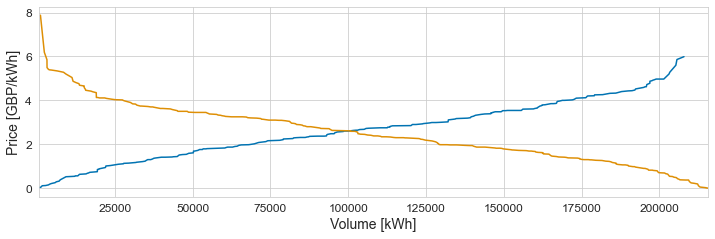

In [7]:
clearing_price, clearing_price_volume = getClearingValues(df_bids_generators,df_bids_consumers, 'price_gbp_kwh')

drawClearingChart(df_bids_generators,df_bids_consumers, 'price_gbp_kwh', 'Price [GBP/kWh]')

In [8]:
#Get the bids that are below the clearing price value for generators and the bids above for consumers.
df_cleared_consumers,df_cleared_generators  =  getClearedDf(df_bids_generators, df_bids_consumers, clearing_price, 'price_gbp_kwh')

In [9]:
print("Total volume to be supplied: {:,.0f} kWh".format(df_cleared_consumers["volume_kwh"].sum()))

Total volume to be supplied: 95,225 kWh


## Calculate clearing carbon intensity value

In [10]:
# Generators and consumers with information about carbon intensity of electricity
df_bids_carbon_generators = df_cleared_generators.loc[df_cleared_generators['carbon_gco2_kwh'].notnull(), :].copy()
df_bids_carbon_consumers = df_cleared_consumers.loc[df_cleared_consumers['carbon_gco2_kwh'].notnull(), :].copy()

Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 40257


(<Figure size 864x252 with 1 Axes>,
 <AxesSubplot:xlabel='Volume [kWh]', ylabel='Carbon intensity [gCO2/kWh]'>)

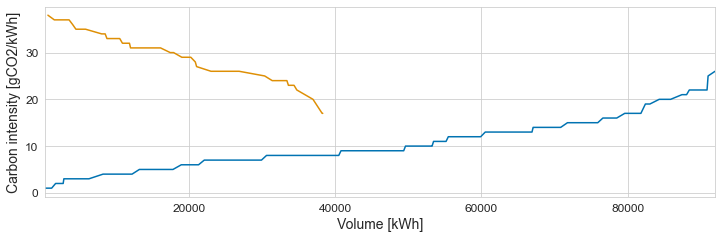

In [11]:
clearing_carbon, clearing_carbon_volume = getClearingValues(df_bids_carbon_generators,df_bids_carbon_consumers , 'carbon_gco2_kwh')
drawClearingChart(df_bids_carbon_generators,df_bids_carbon_consumers , 'carbon_gco2_kwh', 'Carbon intensity [gCO2/kWh]')

In [12]:
df_cleared_carbon_consumers,df_cleared_carbon_generators =  getClearedDf(df_bids_carbon_generators, df_bids_carbon_consumers, clearing_carbon, 'carbon_gco2_kwh')

## Match generators and consumers
loop through consumers and find generators to supply the demand.

In [13]:
# based on carbon intensity and clearing price
list_results = matchingGeneratorsAndConsumers(df_cleared_carbon_generators, df_cleared_carbon_consumers)
carbon_matching = pd.DataFrame(columns = ["Asset Consumers", "Asset Generators", "Volume Exchanged [kWh]"], data=list_results)

In [14]:
# remove consumers and generators already matched

list_generators_already_matched = df_cleared_carbon_generators.loc[df_cleared_carbon_generators['volume_kwh']==0]

df_cleared_generators = df_cleared_generators.loc[~df_cleared_generators['asset'].isin(list_generators_already_matched)]

for index, row in df_cleared_carbon_generators.loc[df_cleared_carbon_generators['volume_kwh']>0].iterrows():
    bid = row['bid']
    updated_volume = row['volume_kwh']
    df_cleared_generators.loc[df_cleared_generators['bid']==bid, 'volume_kwh'] = updated_volume
    
list_consumers_already_matched = df_cleared_carbon_consumers['asset'].values
df_cleared_consumers = df_cleared_consumers.loc[~df_cleared_consumers['asset'].isin(list_consumers_already_matched)]

In [15]:
# based on clearing price only
list_results = matchingGeneratorsAndConsumers(df_cleared_generators, df_cleared_consumers)
price_matching = pd.DataFrame(columns = ["Asset Consumers", "Asset Generators", "Volume Exchanged [kWh]"], data=list_results)

In [16]:
results = pd.concat([carbon_matching, price_matching]) # for timestep 0
print("Total volume supplied: {:,.0f} kWh".format(results["Volume Exchanged [kWh]"].sum()))
results

Total volume supplied: 95,225 kWh


,Asset Consumers,Asset Generators,Volume Exchanged [kWh]
0,a2583,a0475,406
1,a2583,a4593,337
2,a0088,a4593,50
3,a0088,a0034,460
4,a0088,a1159,365
...,...,...,...
138,a0325,a3928,547
139,a1455,a3928,1136
140,a3452,a3928,23
141,a0688,a3928,633


# Running the algorithm for all timesteps

In [17]:
frames = []
historical_clearing_price = []
historical_clearing_CO2 = []
for timestep in df_bids['time'].unique():
    print("Matching algorithm for timestep {0}".format(timestep))
    df_bids_generators = df_bids.loc[(df_bids['volume_kwh']<0) & (df_bids['time'] == timestep), :].copy()
    df_bids_consumers = df_bids.loc[(df_bids['volume_kwh']>0) & (df_bids['time'] == timestep), :].copy()
    df_bids_generators['volume_kwh'] = -df_bids_generators['volume_kwh']
    
    clearing_price, clearing_price_volume = getClearingValues(df_bids_generators,df_bids_consumers, 'price_gbp_kwh')
    historical_clearing_price.append(clearing_price)
    df_cleared_consumers,df_cleared_generators =  getClearedDf(df_bids_generators, df_bids_consumers, clearing_price, 'price_gbp_kwh')
    
    df_bids_carbon_generators = df_cleared_generators.loc[df_cleared_generators['carbon_gco2_kwh'].notnull(), :].copy()
    df_bids_carbon_consumers = df_cleared_consumers.loc[df_cleared_consumers['carbon_gco2_kwh'].notnull(), :].copy()
    clearing_carbon, clearing_carbon_volume = getClearingValues(df_bids_carbon_generators,df_bids_carbon_consumers , 'carbon_gco2_kwh')
    historical_clearing_CO2.append(clearing_carbon)
    df_cleared_carbon_consumers,df_cleared_carbon_generators =  getClearedDf(df_bids_carbon_generators, df_bids_carbon_consumers, clearing_carbon, 'carbon_gco2_kwh')
    
    # Matching based on carbon emissions
    list_results = matchingGeneratorsAndConsumers(df_cleared_carbon_generators, df_cleared_carbon_consumers)
    carbon_matching = pd.DataFrame(columns = ["Asset Consumers", "Asset Generators", "Volume Exchanged [kWh]"], data=list_results)
    
    # remove consumers and generators already matched
    list_generators_already_matched = df_cleared_carbon_generators.loc[df_cleared_carbon_generators['volume_kwh']==0]

    df_cleared_generators = df_cleared_generators.loc[~df_cleared_generators['asset'].isin(list_generators_already_matched)]

    for index, row in df_cleared_carbon_generators.loc[df_cleared_carbon_generators['volume_kwh']>0].iterrows():
        bid = row['bid']
        updated_volume = row['volume_kwh']
        df_cleared_generators.loc[df_cleared_generators['bid']==bid, 'volume_kwh'] = updated_volume

    list_consumers_already_matched = df_cleared_carbon_consumers['asset'].values
    df_cleared_consumers = df_cleared_consumers.loc[~df_cleared_consumers['asset'].isin(list_consumers_already_matched)]
    
    # Matching based on prices
    list_results = matchingGeneratorsAndConsumers(df_cleared_generators, df_cleared_consumers)
    price_matching = pd.DataFrame(columns = ["Asset Consumers", "Asset Generators", "Volume Exchanged [kWh]"], data=list_results)
    
    results = pd.concat([carbon_matching, price_matching]) 
    results['Timestep'] = timestep
    frames.append(results)

Matching algorithm for timestep 0
Clearing price_gbp_kwh is 2.63 and the clearing volume is 101681
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 40257
Matching algorithm for timestep 1
Clearing price_gbp_kwh is 2.56 and the clearing volume is 117321
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 33365
Matching algorithm for timestep 2
Clearing price_gbp_kwh is 2.76 and the clearing volume is 101207
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 29733
Matching algorithm for timestep 3
Clearing price_gbp_kwh is 2.48 and the clearing volume is 115854
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 37815
Matching algorithm for timestep 4
Clearing price_gbp_kwh is 2.73 and the clearing volume is 107868
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 32803
Matching algorithm for timestep 5
Clearing price_gbp_kwh is 2.53 and the clearing volume is 115373
Clearing carbon_gco2_kwh is 6.0 and the clearing volume is 25962
Matching algorit

Matching algorithm for timestep 51
Clearing price_gbp_kwh is 2.5 and the clearing volume is 117383
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 28288
Matching algorithm for timestep 52
Clearing price_gbp_kwh is 2.52 and the clearing volume is 111855
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 33888
Matching algorithm for timestep 53
Clearing price_gbp_kwh is 2.5 and the clearing volume is 114851
Clearing carbon_gco2_kwh is 9.0 and the clearing volume is 36121
Matching algorithm for timestep 54
Clearing price_gbp_kwh is 2.52 and the clearing volume is 110390
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 30550
Matching algorithm for timestep 55
Clearing price_gbp_kwh is 2.6 and the clearing volume is 116339
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 31254
Matching algorithm for timestep 56
Clearing price_gbp_kwh is 2.51 and the clearing volume is 124354
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 29950
Matching algo

Clearing price_gbp_kwh is 2.48 and the clearing volume is 88443
Clearing carbon_gco2_kwh is 9.0 and the clearing volume is 28689
Matching algorithm for timestep 102
Clearing price_gbp_kwh is 2.22 and the clearing volume is 75458
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 30168
Matching algorithm for timestep 103
Clearing price_gbp_kwh is 2.35 and the clearing volume is 79120
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 24936
Matching algorithm for timestep 104
Clearing price_gbp_kwh is 2.53 and the clearing volume is 86765
Clearing carbon_gco2_kwh is 9.0 and the clearing volume is 25269
Matching algorithm for timestep 105
Clearing price_gbp_kwh is 2.45 and the clearing volume is 81448
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 21207
Matching algorithm for timestep 106
Clearing price_gbp_kwh is 2.37 and the clearing volume is 76836
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 20573
Matching algorithm for timestep 107
Clearing p

Matching algorithm for timestep 151
Clearing price_gbp_kwh is 2.51 and the clearing volume is 113318
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 35370
Matching algorithm for timestep 152
Clearing price_gbp_kwh is 2.69 and the clearing volume is 122047
Clearing carbon_gco2_kwh is 6.0 and the clearing volume is 30304
Matching algorithm for timestep 153
Clearing price_gbp_kwh is 2.59 and the clearing volume is 124237
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 39339
Matching algorithm for timestep 154
Clearing price_gbp_kwh is 2.38 and the clearing volume is 132986
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 41020
Matching algorithm for timestep 155
Clearing price_gbp_kwh is 2.59 and the clearing volume is 122148
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 37331
Matching algorithm for timestep 156
Clearing price_gbp_kwh is 2.37 and the clearing volume is 129998
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 42273
Matc

Clearing price_gbp_kwh is 2.61 and the clearing volume is 91874
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 29062
Matching algorithm for timestep 202
Clearing price_gbp_kwh is 2.64 and the clearing volume is 92084
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 24540
Matching algorithm for timestep 203
Clearing price_gbp_kwh is 2.33 and the clearing volume is 84341
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 23965
Matching algorithm for timestep 204
Clearing price_gbp_kwh is 2.35 and the clearing volume is 91696
Clearing carbon_gco2_kwh is 9.0 and the clearing volume is 27916
Matching algorithm for timestep 205
Clearing price_gbp_kwh is 2.4 and the clearing volume is 84313
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 24245
Matching algorithm for timestep 206
Clearing price_gbp_kwh is 2.53 and the clearing volume is 76489
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 19281
Matching algorithm for timestep 207
Clearing pr

Matching algorithm for timestep 251
Clearing price_gbp_kwh is 2.82 and the clearing volume is 90495
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 35024
Matching algorithm for timestep 252
Clearing price_gbp_kwh is 2.38 and the clearing volume is 99803
Clearing carbon_gco2_kwh is 11.0 and the clearing volume is 39960
Matching algorithm for timestep 253
Clearing price_gbp_kwh is 2.53 and the clearing volume is 96439
Clearing carbon_gco2_kwh is 6.0 and the clearing volume is 19827
Matching algorithm for timestep 254
Clearing price_gbp_kwh is 2.4 and the clearing volume is 95978
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 25798
Matching algorithm for timestep 255
Clearing price_gbp_kwh is 2.39 and the clearing volume is 116275
Clearing carbon_gco2_kwh is 8.0 and the clearing volume is 34663
Matching algorithm for timestep 256
Clearing price_gbp_kwh is 2.41 and the clearing volume is 117347
Clearing carbon_gco2_kwh is 7.0 and the clearing volume is 34227
Matching

In [18]:
final_results = pd.concat(frames)

In [19]:
final_results.to_csv("Matched_generators_consumers.csv")

Text(0.5, 0, 'Timesteps')

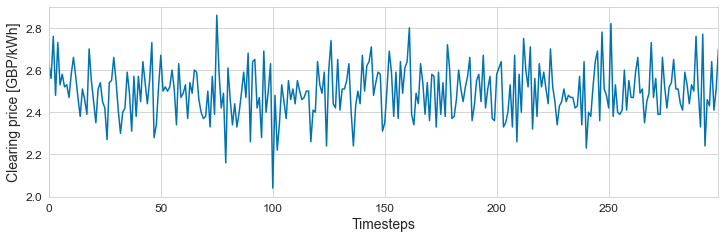

In [20]:
# Historical clearing price

f, ax = plt.subplots(figsize=figsize)
x_arr = [x for x in range(len(historical_clearing_price))]
ax.plot(x_arr, historical_clearing_price)
ax.margins(0,None)
ax.set_ylabel("Clearing price [GBP/kWh]")
ax.set_xlabel("Timesteps")

Text(0.5, 0, 'Timesteps')

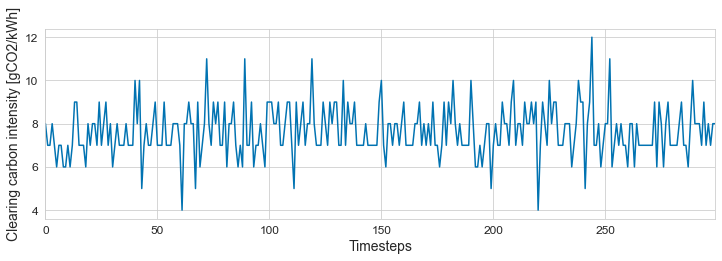

In [21]:
# Historical clearing carbon intensity

f, ax = plt.subplots(figsize=figsize)
x_arr = [x for x in range(len(historical_clearing_CO2))]
ax.plot(x_arr, historical_clearing_CO2)
ax.margins(0,None)
ax.set_ylabel("Clearing carbon intensity [gCO2/kWh]")
ax.set_xlabel("Timesteps")